# ML - IE406 Project

Group Details

**Group - 21**

1. Kushagra Pathak - 201801005
2. Harsh Modi - 201801029
3. Parth Naghera-201801176
4. Harsh Patel - 201801411
5. Vatsal Agrawal-201801053





In [ ]:
!pip install sktime

In [ ]:
!pip install pmdarima

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from sktime.forecasting.arima import AutoARIMA
from pandas import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


In [ ]:
def init():
  warnings.filterwarnings("ignore")
  drive.mount('/content/drive')
  global DATA_PATH, DATASET, BASE_URL
  BASE_URL = '/content/drive/MyDrive/arima_data/'
  DATA_PATH = BASE_URL + 'covid_19_combined.csv'
  DATASET = pd.read_csv(DATA_PATH, parse_dates=['ObservationDate'])
  DATASET.drop('Province/State', axis = 1, inplace = True)
  print("Shapes :\n", f'Combined : {DATASET.shape}\n')


In [ ]:
init()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shapes :
 Combined : (171976, 7)



In [ ]:
DATASET.head()

,ObservationDate,Country,Lat,Long,Confirmed,Deaths,Recovered
0,2020-01-22,Afghanistan,33.93911,67.709953,0,0,0
1,2020-01-23,Afghanistan,33.93911,67.709953,0,0,0
2,2020-01-24,Afghanistan,33.93911,67.709953,0,0,0
3,2020-01-25,Afghanistan,33.93911,67.709953,0,0,0
4,2020-01-26,Afghanistan,33.93911,67.709953,0,0,0


In [ ]:
# Shaping data into time series
data = DATASET
data = data[pd.to_datetime(data.index) <= pd.to_datetime('2021-06-30')]
confirmedCases = data.groupby('ObservationDate').sum()['Confirmed']
deathCases = data.groupby('ObservationDate').sum()['Deaths']
recoveredCases = data.groupby('ObservationDate').sum()['Recovered']

In [ ]:
def analyse(y, lags=None, figsize=(12, 7)):
  
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    time_series_plot = plt.subplot2grid(layout, (0, 0), colspan=2)
    autocorrelation_graph = plt.subplot2grid(layout, (1, 0))
    partial_autocorrelation_graph = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=time_series_plot)
    p_value = sm.tsa.stattools.adfuller(y)[1] # For dicky fuller test
    time_series_plot.set_title('Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    plot_acf(y, lags=lags, ax=autocorrelation_graph)
    plot_pacf(y, lags=lags, ax=partial_autocorrelation_graph)
    plt.tight_layout()

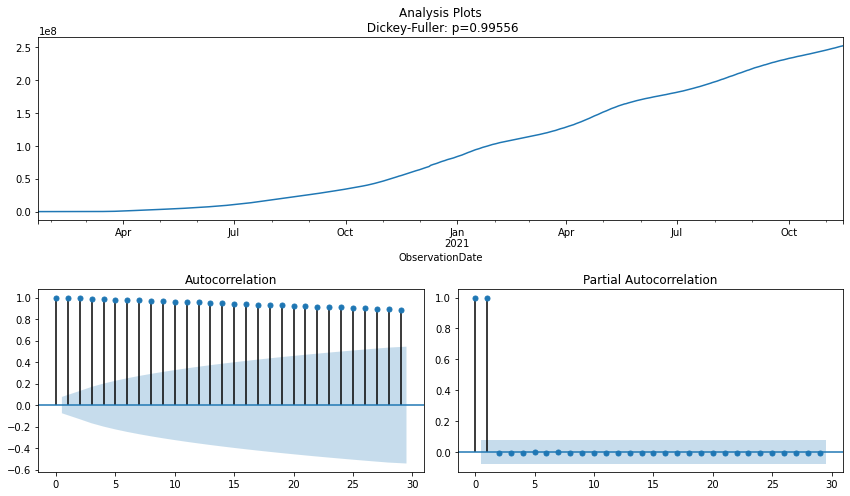

In [ ]:
analyse(confirmedCases)

These results indicate that the data is not stationary and a strong trend can be seen

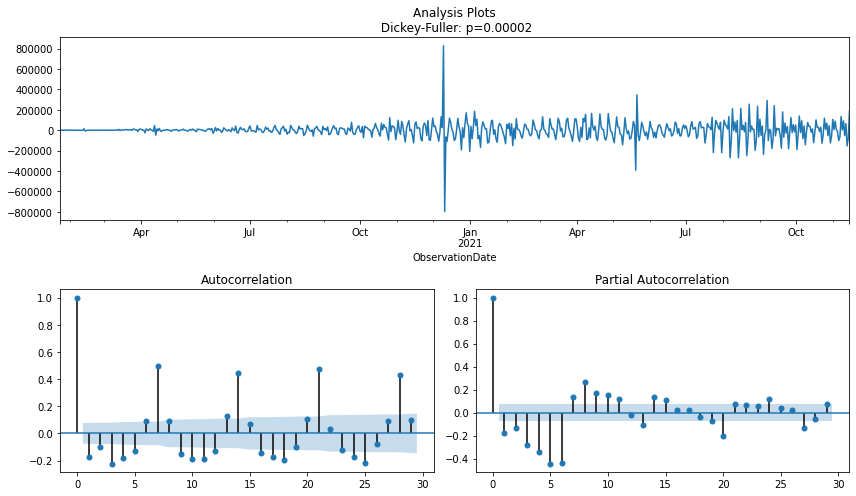

In [ ]:
differenced_data = (confirmedCases - confirmedCases.shift(1)).dropna()
double_differenced_data = (differenced_data - differenced_data.shift(1)).dropna()
analyse(double_differenced_data)

Here p-value is close to 0 so the data now has become stationary after double differencing.

The values p,q,d can be derived from the above plots which are
d = 2, q = 3 (high acf at this lag) , p = 5 (after which the values fade out)

In [ ]:
confirmedCases.index = confirmedCases.index.to_period(freq='D')
test_len = int(len(confirmedCases) * 0.25)
train, test = confirmedCases.iloc[:-test_len], confirmedCases.iloc[-test_len:]

forecaster = AutoARIMA(suppress_warnings=True, seasonal = False)
forecaster.fit(confirmedCases)
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  664
Model:               SARIMAX(5, 2, 2)   Log Likelihood               -8177.226
Date:                Sun, 21 Nov 2021   AIC                          16370.452
Time:                        12:51:11   BIC                          16406.414
Sample:                             0   HQIC                         16384.389
                                - 664                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3860      0.038     10.257      0.000       0.312       0.460
ar.L2         -0.5590      0.028    -20.175      0.000      -0.613      -0.505
ar.L3         -0.3559      0.025    -13.996      0.000      -0.406      -0.306
ar.L4         -0.2703      0.023    -11.506      0.000      -0.316      -0.224
ar.L5         -0.2791      0.038     -7.307      0.000      -0.354      -0.204
ma.L1         -1.1396      0.031    -36.538      0.000      -1.201      -1.078
ma.L2          0.8271      0.023     36.266      0.000       0.782       0.872
sigma2      3.499e+09   1.23e-11   2.83e+20      0.000     3.5e+09     3.5e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            136850.79
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):              31.57   Skew:                             3.60
Prob(H) (two-sided):                  0.00   Kurtosis:                        73.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.07e+36. Standard errors may be unstable.
"""

In [ ]:
def plot_forecast(series_train, series_test, forecast, forecast_int=None):

    mae = mean_absolute_error(series_test, forecast)
    mape = mean_absolute_percentage_error(series_test, forecast)

    plt.figure(figsize=(12, 6))
    plt.title(f"MAE: {mae:.2f}, MAPE: {mape * 100:.3f}", size=18)
    series_train.plot(label="train values", color="b")
    series_test.plot(label="test values", color="g")
    forecast.index = series_test.index
    forecast.plot(label="forecast", color="r")
    print("Shape", forecast.shape)
    if forecast_int is not None:
        plt.fill_between(
            series_test.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.2,
            color="dimgray",
        )
    plt.legend(prop={"size": 16})
    plt.style.use('seaborn-whitegrid')
    plt.xlabel('Observation Date')
    plt.show()

    return mae, mape

Shape (166,)


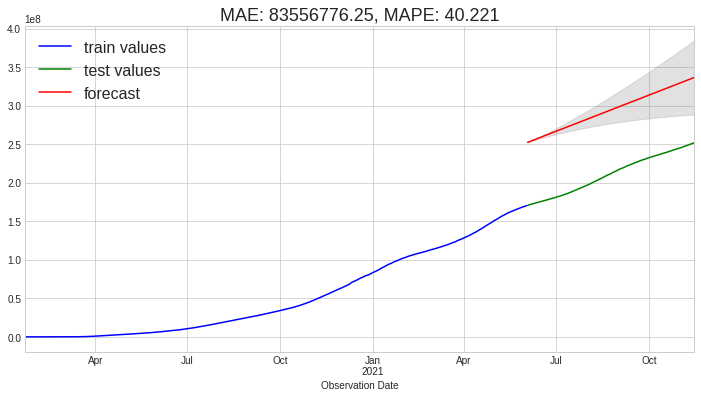

In [ ]:
fh = np.arange(test_len) + 1
forecast, forecast_int = forecaster.predict(fh=fh, return_pred_int=True, alpha=0.05)
mae, mape = plot_forecast(
    train, test, forecast, forecast_int
)

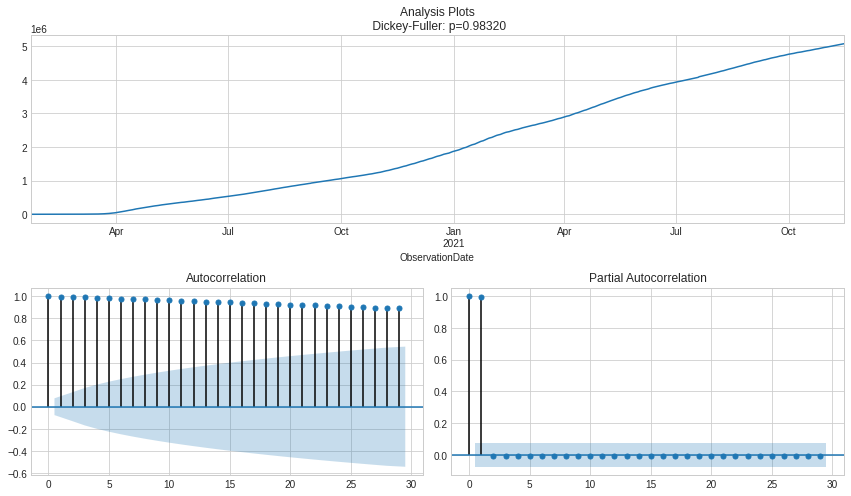

In [ ]:
analyse(deathCases)

These results indicate that the data is not stationary and a strong trend can be seen

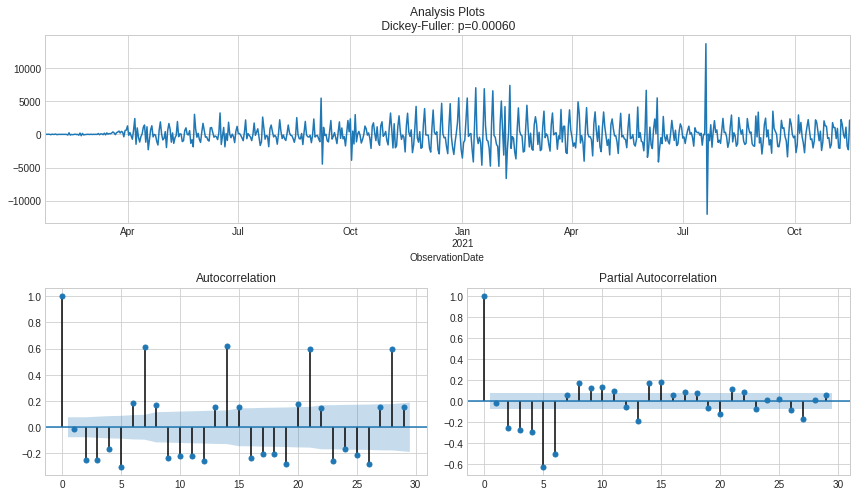

In [ ]:
differenced_data = (deathCases - deathCases.shift(1)).dropna()
double_differenced_data = (differenced_data - differenced_data.shift(1)).dropna()
analyse(double_differenced_data)

Here p-value is close to 0 so the data now has become stationary after double differencing.

The values p,q,d can be derived from the above plots which are
d = 2, q = 5 (high acf at this lag) , p = 5 (after which the values fade out)

In [ ]:
deathCases.index = deathCases.index.to_period(freq='D')
test_len = int(len(deathCases) * 0.25)
train_death, test_death = deathCases.iloc[:-test_len], deathCases.iloc[-test_len:]

forecaster_death = AutoARIMA(suppress_warnings=True, seasonal = False)
forecaster_death.fit(deathCases)
forecaster_death.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  664
Model:               SARIMAX(5, 2, 2)   Log Likelihood               -5576.016
Date:                Sun, 21 Nov 2021   AIC                          11168.032
Time:                        12:51:42   BIC                          11203.994
Sample:                             0   HQIC                         11181.969
                                - 664                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2589      0.033      7.750      0.000       0.193       0.324
ar.L2         -0.6950      0.030    -22.874      0.000      -0.755      -0.635
ar.L3         -0.3179      0.034     -9.446      0.000      -0.384      -0.252
ar.L4         -0.2998      0.030    -10.101      0.000      -0.358      -0.242
ar.L5         -0.4913      0.037    -13.378      0.000      -0.563      -0.419
ma.L1         -0.9783      0.032    -30.163      0.000      -1.042      -0.915
ma.L2          0.6974      0.030     22.978      0.000       0.638       0.757
sigma2      1.291e+06   2.32e+04     55.591      0.000    1.25e+06    1.34e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):             19256.72
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               5.03   Skew:                             2.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

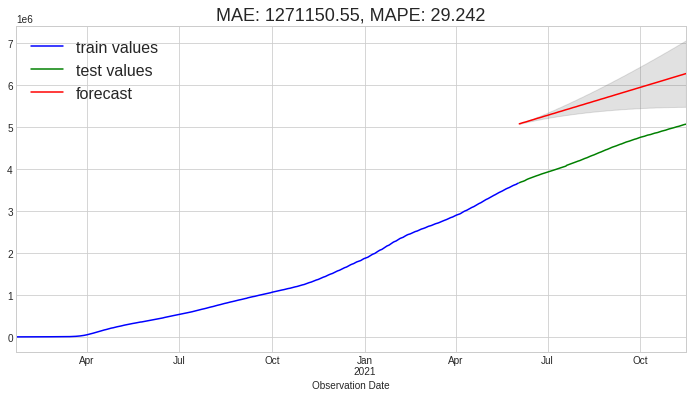

In [ ]:
forecast_death, forecast_int_death = forecaster_death.predict(fh=fh, return_pred_int=True, alpha=0.05)
mae_death, mape_death = plot_forecast(
    train_death, test_death, forecast_death, forecast_int_death
)

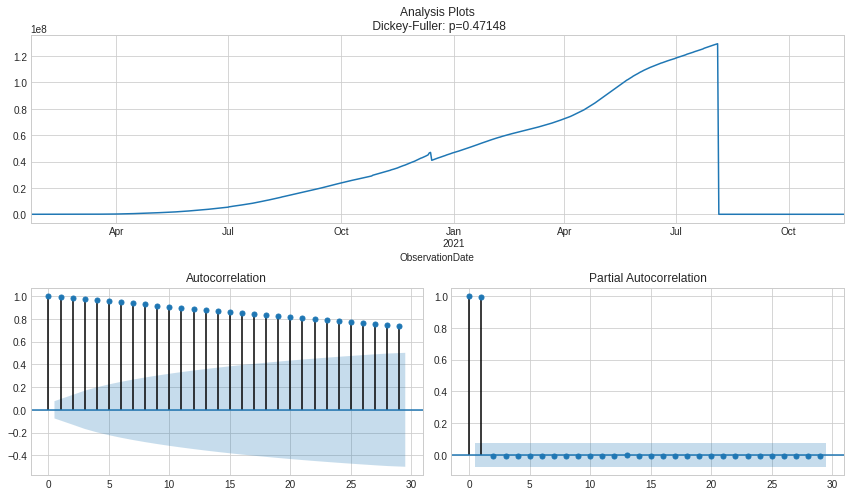

In [ ]:
analyse(recoveredCases)

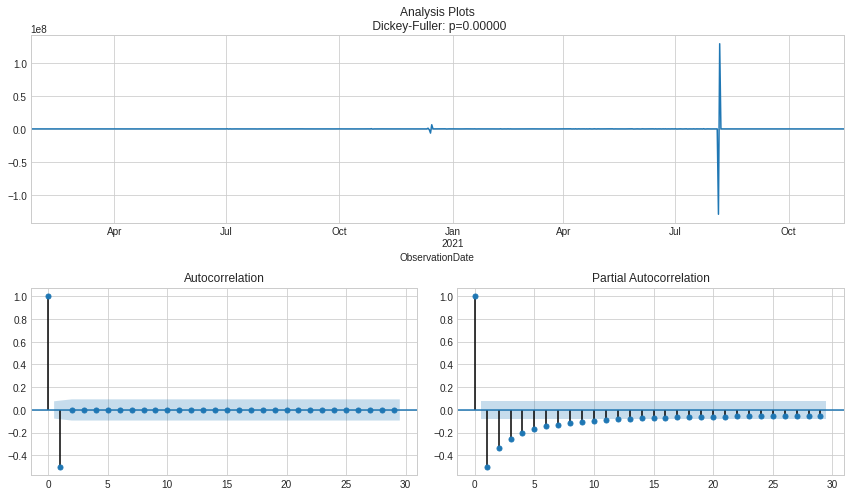

In [ ]:
differenced_data = (recoveredCases - recoveredCases.shift(1)).dropna()
double_differenced_data = (differenced_data - differenced_data.shift(1)).dropna()
analyse(double_differenced_data)

In [ ]:
recoveredCases.index = recoveredCases.index.to_period(freq='D')
test_len = int(len(recoveredCases) * 0.25)
train_rec, test_rec = recoveredCases.iloc[:-test_len], recoveredCases.iloc[-test_len:]

forecaster_recovered = AutoARIMA(suppress_warnings=True, seasonal = False)
forecaster_recovered.fit(recoveredCases)
forecaster_recovered.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  664
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -11172.381
Date:                Sun, 21 Nov 2021   AIC                          22346.763
Time:                        12:51:45   BIC                          22351.259
Sample:                             0   HQIC                         22348.505
                                - 664                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.533e+13   7.68e+10    330.019      0.000    2.52e+13    2.55e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          11855763.87
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):            6563.78   Skew:                           -25.55
Prob(H) (two-sided):                  0.00   Kurtosis:                       656.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

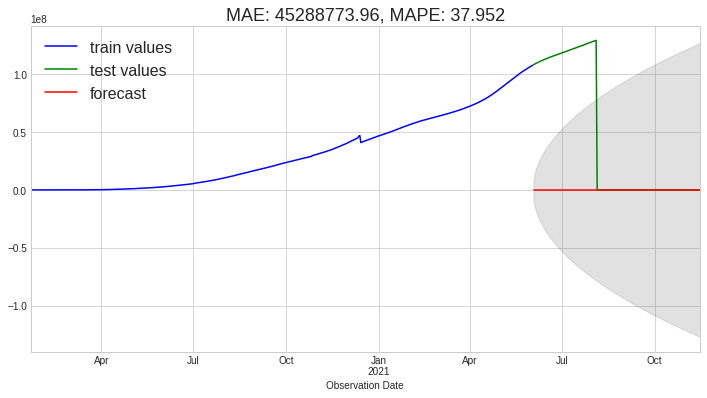

In [ ]:
forecast_recovered, forecast_int_recovered = forecaster_recovered.predict(fh=fh, return_pred_int=True, alpha=0.05)
mae_recovered, mape_recovered = plot_forecast(
    train_rec, test_rec, forecast_recovered, forecast_int_recovered
)

In [ ]:
fh = np.arange(test_len + 6 * 30) + 1
forecast, forecast_int = forecaster.predict(fh=fh, return_pred_int=True, alpha=0.05)
forecast_death, forecast_int_death = forecaster_death.predict(fh=fh, return_pred_int=True, alpha=0.05)
forecast_recovered, forecast_int_recovered = forecaster_recovered.predict(fh=fh, return_pred_int=True, alpha=0.05)

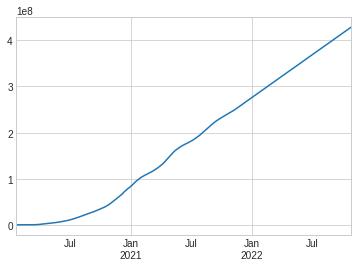

In [ ]:
finalPredictionConfirmed = confirmedCases.append(forecast)
finalPredictionConfirmed.plot()
plt.show()

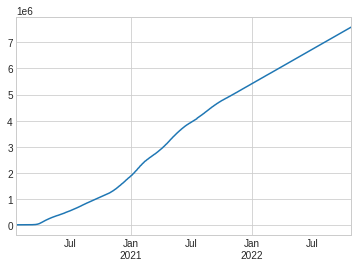

In [ ]:
finalPredictionDeath = deathCases.append(forecast_death)
finalPredictionDeath.plot()
plt.show()

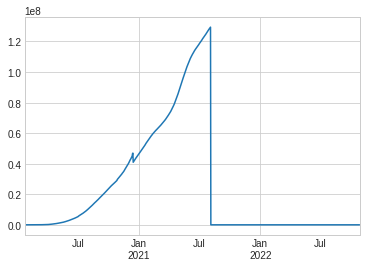

In [ ]:
finalPredictionRecovered = recoveredCases.append(forecast_recovered)
finalPredictionRecovered.plot()
plt.show()

In [ ]:
print('Evaluation Metrics :\n', f'MAE and MAPE for Confirmed Cases {mae}, {mape}\n', 
      f'MAE and MAPE for Death Cases {mae_death}, {mape_death}\n', 
      f'MAE and MAPE for Recovered Cases {mae_recovered}, {mape_recovered}\n')

Evaluation Metrics :
 MAE and MAPE for Confirmed Cases 83556776.25422736, 0.4022089664712856
 MAE and MAPE for Death Cases 1271150.5540401097, 0.2924164456500699
 MAE and MAPE for Recovered Cases 45288773.96385542, 0.3795180722891566

